# 正式

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [2]:
train = pd.read_csv("data/data.csv")

In [3]:
train.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [4]:
test = pd.read_csv("data/test.csv")

In [5]:
test.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
1458,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


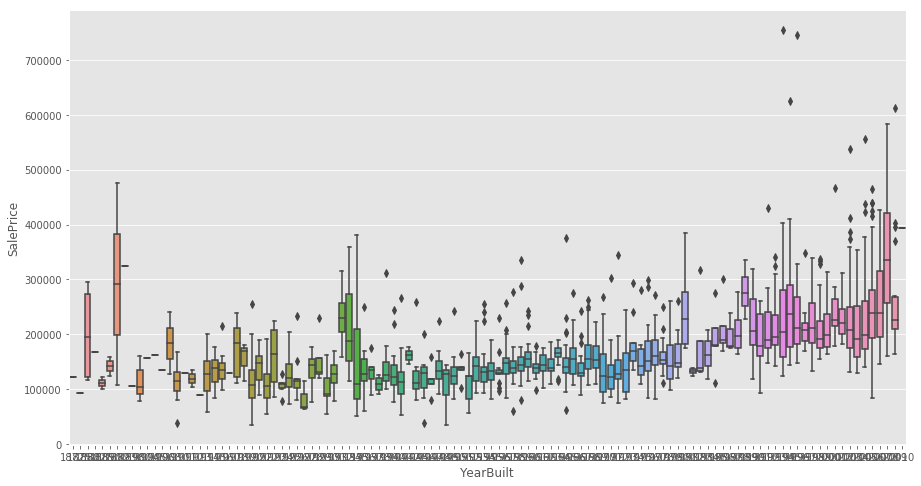

In [6]:
# 可视化，新建造的房屋价格高？
plt.figure(figsize=(15,8))
sns.boxplot(train.YearBuilt, train.SalePrice)

(0, 800000)

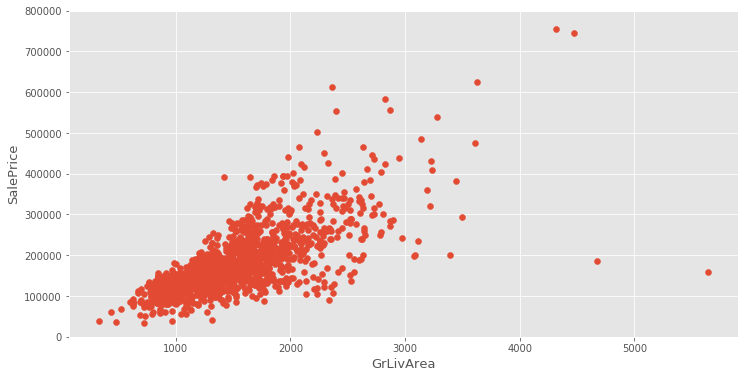

In [7]:
# 去掉噪声
plt.figure(figsize=(12,6))
plt.scatter(x=train.GrLivArea, y=train.SalePrice)
plt.xlabel("GrLivArea", fontsize=13)
plt.ylabel("SalePrice", fontsize=13)
plt.ylim(0,800000)

## 去掉噪声
- 去掉这几个样本之后，训练集上分数有所升高，但是在提交到kaggle后表现较好，说明没去掉这几个点，可能过拟合了。

In [8]:
train.drop(train[(train["GrLivArea"]>4000) & (train["SalePrice"]<300000)].index, inplace=True)
train.drop(train[(train["OverallQual"]<5) & (train["SalePrice"]>200000)].index, inplace=True)

In [9]:
data = pd.concat([train,test], ignore_index=True)

In [10]:
data.tail()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
2914,546,546,0,NaN,3,Twnhs,TA,No,0.0,0.0,...,WD,0,Pave,5,546.0,AllPub,0,1970,1970,2006
2915,546,546,0,NaN,3,TwnhsE,TA,No,252.0,0.0,...,WD,0,Pave,6,546.0,AllPub,0,1970,1970,2006
2916,1224,0,0,NaN,4,1Fam,TA,No,1224.0,0.0,...,WD,0,Pave,7,1224.0,AllPub,474,1960,1996,2006
2917,970,0,0,NaN,3,1Fam,TA,Av,337.0,0.0,...,WD,0,Pave,6,912.0,AllPub,80,1992,1992,2006
2918,996,1004,0,NaN,3,1Fam,TA,Av,758.0,0.0,...,WD,0,Pave,9,996.0,AllPub,190,1993,1994,2006


In [11]:
data.drop(['Id'],axis=1, inplace=True)
data.shape

(2919, 80)

## 特征工程与数据填充

In [13]:
# 查看确实值情况
def getnullcount():
    x = data.isnull().sum()
    print(x[x>0].sort_values())
    x[x>0].sort_values().plot.bar()

GarageArea         1
SaleType           1
KitchenQual        1
BsmtFinSF1         1
BsmtFinSF2         1
GarageCars         1
TotalBsmtSF        1
Exterior2nd        1
Exterior1st        1
BsmtUnfSF          1
Electrical         1
Functional         2
Utilities          2
BsmtHalfBath       2
BsmtFullBath       2
MSZoning           4
MasVnrArea        23
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtCond          82
BsmtExposure      82
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageQual       159
LotFrontage      486
FireplaceQu     1420
SalePrice       1459
Fence           2348
Alley           2721
MiscFeature     2814
PoolQC          2909
dtype: int64


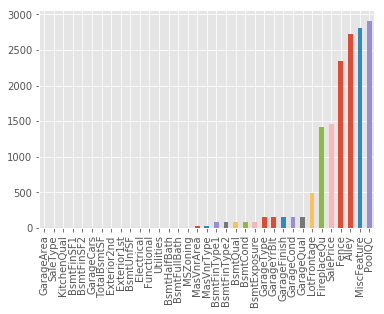

In [14]:
getnullcount()

In [15]:
data["LotAreaCut"] = pd.qcut(data.LotArea,10)
data['LotFrontage'] = data.groupby(['LotAreaCut', 'Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
data['LotFrontage']= data.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [16]:
cols = ["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    data[col].fillna(0, inplace=True)

cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    data[col].fillna("None", inplace=True)

cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    data[col].fillna(data[col].mode()[0], inplace=True)


SalePrice    1459
dtype: int64


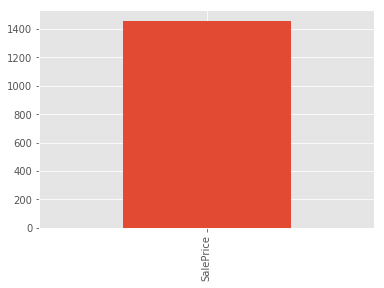

In [17]:
getnullcount()

In [18]:
# data = data.drop(['SqrtLotArea'], axis=1)
data = data.drop(['LotAreaCut'], axis=1)

## 数据集准备与模型训练

In [19]:
def dummies_data(train, all_data):
    y = train.SalePrice
    n_train = train.shape[0]
    data_1 = all_data.drop(['SalePrice'], axis=1)
    data_1 = pd.get_dummies(data_1)
    X = data_1[:n_train]
    X_real_test = data_1[n_train:]
    return X, y, X_real_test

In [20]:
X,y,X_real_test = dummies_data(train, data)

In [21]:
def drop_feature_data(train, all_data):
    y = train.SalePrice
    n_train = train.shape[0]
    
    c = train.corr()['SalePrice']
    data_2 = data.drop(['SalePrice'], axis=1)
    data_2.drop(c[(c > 0.0) & (c < 0.1)].index.tolist(),axis=1)
    data_2 = pd.get_dummies(data_2)
    
    X = data_2[:n_train]
    X_real_test = data_2[n_train:]
    return X,y,X_real_test

In [22]:
X.shape

(1460, 405)

In [23]:
X_real_test.shape

(1459, 405)

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2,random_state=123)

In [25]:
xg_reg = xgb.XGBRegressor(objective='reg:linear',
                        colsample_bytree=0.7,
                        learning_rate=0.01,
                        max_depth=3,
                        n_estimators=3000,
                        subsample=0.7,
                        reg_alpha=0.0006,
                        nthread=6)

In [26]:
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=3000,
       n_jobs=1, nthread=6, objective='reg:linear', random_state=0,
       reg_alpha=0.0006, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

In [27]:
def benchmark(model, X_test, y_test):
    pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    logrmse = np.sqrt(mean_squared_error(np.log(y_test), np.log(pred)))
    print("RMSE: {} \nLOGRMSE: {}".format(rmse, logrmse))
    return rmse, logrmse

In [28]:
benchmark(xg_reg, X_test, y_test)
# RMSE: 23403.265354595704 
# LOGRMSE: 0.10319914493109959

# 删除SqrtLotArea
#RMSE: 19423.18282625528 
#LOGRMSE: 0.111856728563305

# RMSE: 23217.054828354438 
# LOGRMSE: 0.10222134836625894

RMSE: 22996.13516342158 
LOGRMSE: 0.1019755663180463


(22996.13516342158, 0.1019755663180463)

In [54]:
def test_data_set(data_set):
    y = train['SalePrice']
    data_set = data_set.drop(['SalePrice'], axis=1)
    data_set = pd.get_dummies(data_set)
    X_train, X_test, y_train,y_test = train_test_split(data_set,y,test_size=0.2,random_state=123)
    xg_reg=xgb.XGBRegressor(objective='reg:linear',colsample_bytree=0.7,learning_rate=0.01,max_depth=3,n_estimators=3000,subsample=0.7,reg_alpha=0.0006,nthread=6)
    xg_reg.fit(X_train,y_train)
    benchmark(xg_reg, X_test, y_test)

In [62]:
test_data_set(X_1.drop(c[(c > 0.0) & (c < 0.1)].index.tolist(),axis=1))

KeyboardInterrupt: 

In [57]:
X_1.shape

(1457, 80)

In [29]:
X_train_all, y_all, X_real_test = drop_feature_data(train, data)
print(X_train_all.shape)
print(X_real_test.shape)

xg_reg = xgb.XGBRegressor(objective='reg:linear',
                        colsample_bytree=0.7,
                        learning_rate=0.01,
                        max_depth=3,
                        n_estimators=3000,
                        subsample=0.7,
                        reg_alpha=0.0006,
                        nthread=6)
xg_reg.fit(X_train_all, y_all)

pred = xg_reg.predict(X_real_test)
result = pd.DataFrame({'Id':test['Id'], 'SalePrice':pred})
result.to_csv("data/submission_4.csv", index=False)

(1460, 405)
(1459, 405)


In [30]:
sub = pd.read_csv("data/submission_4.csv")
sub

,Id,SalePrice
0,1461,123884.660
1,1462,165522.360
2,1463,186184.580
3,1464,190399.620
4,1465,187171.730
5,1466,173620.220
6,1467,171439.160
7,1468,165699.190
8,1469,184289.420
9,1470,127179.770


-第二次提交，去除噪声点；去掉正相关且相关性小的特征。分数只提高了0.12699->0.12695.哭~